## Using K-means to Find Out the Number of Topics in the Article

Here we assume that each article contains mutiple topics (or key sentences), by using `K-means`, we try to group the sentences within same topic together. 

### Data preprocessing
We continue using `ON TACTICS AGAINST JAPANESE IMPERIALISM`, written by `Mao`, which we can compare to our early result.

In [1]:
# read in data
text = ''

with open('data/ON_TACTICS_AGAINST_JAPANESE_IMPERIALISM.txt', 'r') as reader:
    text = reader.read()
    
    
len(text)

44958

In [2]:
# remove reference mark, e.g. '[1]'

import re

text = re.sub(r'\[\d{1,3}\]' ,'', text)
len(text)

44819

In [3]:
# using nltk, split text into sentences

from nltk.tokenize import sent_tokenize

sentences = sent_tokenize(text)

len(sentences)

332

## TF-IDF remove 'stop sentences'(skip)


We use `TF-IDF` to find out the words that are not so important, if one sentences contains too many non-important words, we can try to remove it

In [4]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string


def remove_punctuation_marks(text) :
    punctuation_marks = dict((ord(punctuation_mark), None) for punctuation_mark in string.punctuation)
    return text.translate(punctuation_marks)

def get_lemmatized_tokens(text) :
    normalized_tokens = word_tokenize(remove_punctuation_marks(text.lower()))
    return [WordNetLemmatizer().lemmatize(normalized_token) for normalized_token in normalized_tokens]


In [14]:
# import nltk
# nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/ke.na/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [22]:
tfidf_results = TfidfVectorizer(tokenizer = get_lemmatized_tokens).fit_transform(sentences)
tfidf_results.shape

(332, 1416)

In [23]:
tfidf_results.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
# find out the avg tf-idf scores
not_zero_count = 0
total = 0

for s in tfidf_results.toarray():
    for w in s:
        if w != 0 :
            not_zero_count += 1
            total += w
            
avg_score = total/not_zero_count
avg_score

0.21145994194377424

In [29]:
# define threshold = 0.5 avg
# count the sentence that have more than 50% words below the threshold

threshold = avg_score * 0.5

idx_below_threshold = []

for idx, s in enumerate(tfidf_results.toarray()):
    not_zero_count = 0
    below = 0
    # check whole sentence
    for w in s:
        if w != 0 :
            not_zero_count += 1
            if w < threshold:
                below += 1
    if below / not_zero_count >= 0.5:
        idx_below_threshold.append(idx)
    #print(below / not_zero_count)
        
idx_below_threshold

[208]

In [30]:
sentences[208]

'Without a proper estimate of the strong and weak points of the Japanese and Chinese counter-revolutionary forces and of the Chinese revolutionary forces, we shall be unable fully to understand the necessity of organizing a broad revolutionary national united front, or to take firm measures to break down closed-doorism, or to use the united front as a means of organizing and rallying millions of people and all the armies that are potentially friendly to the revolution for the purpose of advancing to strike at our main target, namely, Japanese imperialism and its running dogs, the Chinese traitors, or to use this tactical weapon of ours to strike at the main target before us, but instead we shall aim at a variety of targets so that our bullets will hit not the principal enemy but our lesser enemies or even our allies.'

## BERT embedding for k-means

In [4]:
## get embedding 

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

sentence_embeddings = model.encode(sentences)

sentence_embeddings

array([[ 0.44056144,  0.5195048 ,  2.5450442 , ...,  0.5283022 ,
        -0.46262807,  0.19722113],
       [-0.24993764, -0.7121983 ,  1.2375451 , ..., -1.0851908 ,
        -0.77441585,  0.10610564],
       [-0.331048  , -0.12393019,  1.3653917 , ..., -0.72380173,
        -0.92983496,  0.26965213],
       ...,
       [ 0.19709875, -0.39470232,  3.0218735 , ..., -0.4574634 ,
        -0.34476504,  0.0278206 ],
       [ 0.52104473, -0.29295123,  1.9758993 , ...,  0.1811067 ,
        -0.92158616, -0.10381993],
       [-0.7256513 ,  0.35026634,  0.09495329, ..., -0.47348344,
        -0.92776227, -0.3470151 ]], dtype=float32)

In [5]:
from sklearn.preprocessing import normalize
# normalize the data help k-means get better performance
norm_data = normalize(sentence_embeddings, norm='l2')

## K-means with Gap statistic

The `K` for `K-means` alogrithm is a key parameter. To pick up a reasonable `K`, here we introduce the `Gap statistic` meathod ([detail](https://statweb.stanford.edu/~gwalther/gap)).  `Gap statistic` can estimate the number of clusters in a set of data.

We use `gap_statistic` package to do that, see implementation detail at: https://github.com/milesgranger/gap_statistic

In [6]:
# ! pip install --upgrade gap-stat

In [7]:
from gap_statistic import OptimalK

optimalK = OptimalK(n_jobs=4, parallel_backend='joblib')

In [8]:
import numpy as np
# limit to 1~15 cluster
n_clusters = optimalK(norm_data, cluster_array=np.arange(1, 15))

In [9]:
optimalK.gap_df.head()

,n_clusters,gap_value,gap*,ref_dispersion_std,sk,sk*,diff,diff*
0,1.0,0.960743,321.745553,0.298014,0.000660,371.519922,-0.114874,374.520306
1,2.0,1.076499,341.139657,0.395194,0.000882,393.914410,-0.047205,395.134837
2,3.0,1.124919,349.027162,0.544202,0.001215,403.022342,-0.018987,403.511158
3,4.0,1.147432,352.163776,1.575640,0.003526,406.647772,-0.039321,407.429844
4,5.0,1.188937,357.235609,0.971853,0.002183,412.501677,-0.015363,412.598645


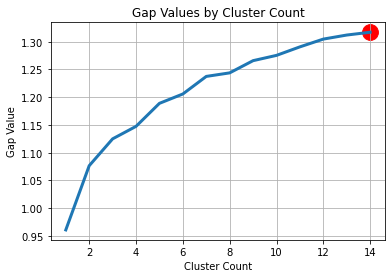

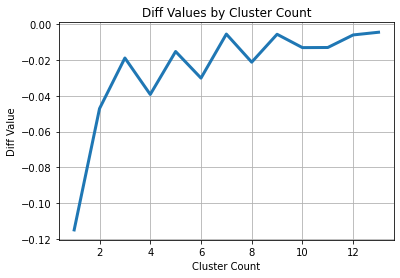

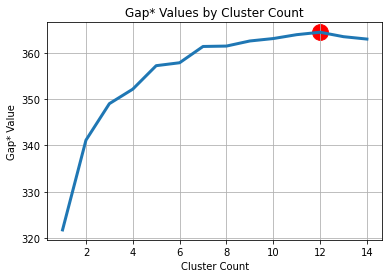

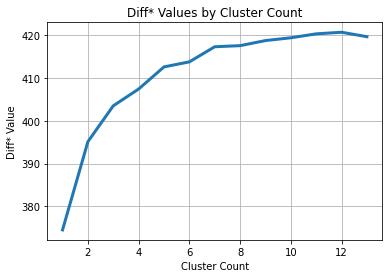

In [10]:
optimalK.plot_results()

In [11]:
# using the best K = 12 for k-means
from sklearn.cluster import KMeans
km = KMeans(
    n_clusters=12, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(norm_data)

y_km

array([ 3,  6,  6,  3,  7, 11,  7,  7,  5, 11, 11,  6, 11,  5,  3,  1, 11,
        1,  1,  3,  3,  3, 11,  2,  1,  9,  5, 11,  4,  5,  9,  2,  0, 10,
        5, 11,  5,  5,  0,  6,  5,  6,  3,  5,  4,  7,  9,  7,  6,  9, 11,
       11,  7,  5,  4,  6,  6,  0,  6, 11,  2,  5, 10,  1, 10, 11,  5,  4,
        9,  6, 11, 11,  3, 11,  8,  5,  1,  6,  7,  3,  5,  5,  5,  5, 10,
       10,  4,  1,  1, 10,  7,  8,  5,  3,  5,  1,  5,  2,  5,  7,  1,  9,
       10, 10,  3,  0,  9,  0,  1,  7, 11, 11, 11, 11, 11, 11,  0,  9, 10,
        3,  3,  3,  5,  3,  3,  3,  2,  4,  4,  8, 10,  5,  8,  8,  8, 11,
        1,  8,  3,  8,  1,  9,  8, 11,  1,  8,  8, 10,  8, 11,  7,  4,  9,
        6,  1,  1,  4,  8,  5,  1,  8,  1,  1,  8,  1,  1,  1,  1,  6,  8,
        1,  2,  6,  8,  6,  7,  7,  1,  1,  7,  7,  7,  3,  7,  6,  5,  7,
       11,  6,  8,  1,  9,  9,  7,  7,  7,  7,  3, 10,  3,  6,  9,  9,  9,
        9,  1,  9,  7,  1,  9,  9,  5, 10,  9,  4,  9,  0,  4,  1, 10,  4,
        5,  4,  3,  2,  4

In [12]:

## create a array that assign each sentence to its group
groups = []

for i in range (0, 12):
    groups.append([])

groups  

[[], [], [], [], [], [], [], [], [], [], [], []]

In [13]:
for idx, embed in enumerate(norm_data):
    groups[y_km[idx] - 1].append(idx)

In [14]:
# validate
group0 = 0
for x in y_km:
    if x == 1:
        group0 += 1

len(groups[0]) == group0

True

In [15]:
groups[0]

[15,
 17,
 18,
 24,
 63,
 76,
 87,
 88,
 95,
 100,
 108,
 136,
 140,
 144,
 154,
 155,
 159,
 161,
 162,
 164,
 165,
 166,
 167,
 170,
 177,
 178,
 190,
 205,
 208,
 218,
 232,
 236,
 248,
 256,
 257,
 258,
 268,
 270,
 316,
 320,
 323,
 324,
 326]

In [16]:
def get_sum_distances(group):
    """input a group indicis of sentences, get a list of sum of cosine distance between
    current sentence and other sentences in the text(score)
    @param: a group of index, index of sentence
    @return score(float)
    """
    # construct data for group info
    data = np.array([norm_data[i] for i in group])
    # to store the result
    res = []
    
    for idx, _ in enumerate(data):
        # data has been normalized, cosine distanct can be calculated as np.dot()
        scores = np.dot(data, data[idx].T)
        res.append(np.sum(scores))
    return res

In [17]:
## pick up top score for each group

for idx, group in enumerate(groups):
    score_list = get_sum_distances(group)
    max_idx = np.argmax(score_list)
    print('Group:' + str(idx + 1) + ': \n')
    print(sentences[group[max_idx]])
    print('\n')

Group:1: 

The Japanese imperialists' policy of subjugating China and Chiang Kai-shek's policy of betraying China will inevitably drive many people over to our side--either directly into joining the ranks of the Communist Party and the Red Army or into forming a united front with us.


Group:2: 

However if the national bourgeoisie joins the anti-imperialist united front, the working class and the national bourgeoisie will have interests in common.


Group:3: 

Why?


Group:4: 

Nevertheless, it cannot be said that in the present circumstances there is no difference between the national bourgeoisie and the landlord and comprador classes.


Group:5: 

The result was that when imperialism ordered its lackeys, the landlord and comprador classes, to spread their numerous tentacles and draw over first Chiang Kai-shek and then Wang Ching-wei, the revolution suffered defeat.


Group:6: 

When the revolutionary situation changes, revolutionary tactics and methods of leadership must change acco

## Remove the sentence that doesn't have too much meaning

In `Group 6`, we got the key sentence: `Today things are different`, this seems doesn't say too much. So we need to try to remove these kind of sentence.

By using Bayesian based anti-spam filter, we can identify the sentence which is not meaningful. We use a pretrained filter `antispam`

In [17]:
# ! pip install antispam

     |████████████████████████████████| 1.5 MB 3.9 MB/s eta 0:00:01
  Created wheel for antispam: filename=antispam-0.0.10-py3-none-any.whl size=1508093 sha256=ea4d3e23b9e0f923a3e63b8470f62196ea7d6ee04c57235818b18ce32827a7ff
  Stored in directory: /home/ke.na/.cache/pip/wheels/0b/90/3f/1e31f5763d03ed2786886841decabe942209fdb4ceed32aace
Successfully built antispam


In [18]:
import antispam

filter_out = []



# apply the filter
for idx, sc in enumerate(sentences):
    is_spam = False
    try:
        is_spam = antispam.is_spam(sc)
    except:
        # bug when sentence is too short
        print('Error during handling:' + str(idx))
    # filter out short sentence: len <= 10    
    if(len(sc) <= 10):
            is_spam = True
    if(is_spam):
        filter_out.append(idx)
        
filter_out

Error during handling:124
Error during handling:297


[0,
 4,
 7,
 19,
 20,
 21,
 24,
 27,
 28,
 30,
 31,
 34,
 35,
 36,
 37,
 38,
 40,
 43,
 44,
 49,
 51,
 53,
 57,
 60,
 70,
 74,
 78,
 84,
 93,
 94,
 97,
 98,
 103,
 124,
 127,
 136,
 138,
 140,
 141,
 143,
 146,
 154,
 155,
 159,
 160,
 161,
 162,
 164,
 166,
 170,
 173,
 177,
 178,
 179,
 180,
 192,
 198,
 211,
 214,
 216,
 217,
 221,
 223,
 227,
 228,
 231,
 232,
 244,
 247,
 248,
 251,
 252,
 263,
 268,
 272,
 274,
 279,
 281,
 282,
 283,
 284,
 285,
 290,
 293,
 294,
 295,
 297,
 307,
 314,
 318,
 319,
 323,
 327]

In [19]:
## create new groups (after filter)
new_groups = []

for i in range (0, 12):
    new_groups.append([])

new_groups  

[[], [], [], [], [], [], [], [], [], [], [], []]

In [20]:
for idx, embed in enumerate(norm_data):
    if(idx not in filter_out):
        new_groups[y_km[idx] - 1].append(idx)
        
new_groups

[[15,
  17,
  18,
  63,
  76,
  87,
  88,
  95,
  100,
  108,
  144,
  165,
  167,
  190,
  205,
  208,
  218,
  236,
  256,
  257,
  258,
  270,
  316,
  320,
  324,
  326],
 [23,
  126,
  171,
  224,
  240,
  266,
  273,
  275,
  287,
  288,
  289,
  292,
  296,
  298,
  299,
  301,
  305],
 [3,
  14,
  42,
  72,
  79,
  104,
  119,
  120,
  121,
  123,
  125,
  182,
  197,
  199,
  245,
  255,
  330],
 [54, 67, 86, 128, 151, 156, 220, 222, 225, 234, 261, 265, 302, 317],
 [8,
  13,
  26,
  29,
  61,
  66,
  75,
  80,
  81,
  82,
  83,
  92,
  96,
  122,
  131,
  158,
  185,
  249,
  250,
  253,
  259,
  260,
  277,
  303,
  304,
  313,
  321,
  322],
 [1,
  2,
  11,
  39,
  41,
  48,
  55,
  56,
  58,
  69,
  77,
  153,
  168,
  172,
  174,
  184,
  188,
  200,
  230,
  246,
  271,
  276,
  300,
  308,
  309,
  310,
  328,
  329],
 [6,
  45,
  47,
  52,
  90,
  99,
  109,
  150,
  175,
  176,
  181,
  183,
  186,
  193,
  194,
  195,
  196,
  207,
  311,
  312,
  331],
 [91, 129, 132

In [21]:
## pick up top score for each group

for idx, group in enumerate(new_groups):
    score_list = get_sum_distances(group)
    max_idx = np.argmax(score_list)
    print('Group:' + str(idx + 1) + ': \n')
    print(sentences[group[max_idx]])
    print('\n')

Group:1: 

The Japanese imperialists' policy of subjugating China and Chiang Kai-shek's policy of betraying China will inevitably drive many people over to our side--either directly into joining the ranks of the Communist Party and the Red Army or into forming a united front with us.


Group:2: 

However if the national bourgeoisie joins the anti-imperialist united front, the working class and the national bourgeoisie will have interests in common.


Group:3: 

Is that correct?


Group:4: 

Nevertheless, it cannot be said that in the present circumstances there is no difference between the national bourgeoisie and the landlord and comprador classes.


Group:5: 

The anti-Japanese operations of Ma Chan-shan  in the three northeastern provinces represented another split in the ruling class camp.


Group:6: 

When the revolutionary situation changes, revolutionary tactics and methods of leadership must change accordingly.


Group:7: 

Owing to the Chinese people's struggle against imperia

In [23]:
## print out avg sentences long in each group
for idx, group in enumerate(new_groups):
    # number of sentence in each group
    count = 0
    # total len in each group
    sen_len =0
    for se in group:
        count += 1
        sen_len += len(sentences[se])
    print('Group:' + str(idx + 1) + ': \n')
    print('Avg length:' + str(sen_len // count))
    print('\n')

Group:1: 

Avg length:207


Group:2: 

Avg length:156


Group:3: 

Avg length:32


Group:4: 

Avg length:110


Group:5: 

Avg length:159


Group:6: 

Avg length:85


Group:7: 

Avg length:177


Group:8: 

Avg length:73


Group:9: 

Avg length:93


Group:10: 

Avg length:162


Group:11: 

Avg length:100


Group:12: 

Avg length:115




We notice that group 3 has least Avg length and the key sentence we got for group 3, as it should be, is short (`Is that correct?`). The grouping algorithm tends to group the sort sentences together. In application, we might need to discard this group.